In [25]:
# Lets install all the needed Libaries
!pip install streamlit --quiet
# Data Handling & Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Optional: interactive visualization
import plotly.express as px

# Dataset fetching
from ucimlrepo import fetch_ucirepo

# App Deployment
import streamlit as st
import pickle

# Optional: model serialization alternative
import joblib

# Optional: model interpretability
import shap
from sklearn.inspection import permutation_importance

In [26]:
# Fetch dataset and combine into a single DataFrame
!pip install ucimlrepo scikit-learn pandas numpy

from ucimlrepo import fetch_ucirepo
import pandas as pd


bc_wisconsin = fetch_ucirepo(id=17)
X = bc_wisconsin.data.features
y = pd.Series(bc_wisconsin.data.targets.iloc[:, 0], name='target')


df = pd.concat([pd.DataFrame(X), y], axis=1)
df.tail()


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,target
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,M
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,M
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,M
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,M
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,B


In [27]:
# Define a path in Google Drive to save the models and create the directory for the files

from google.colab import drive
drive.mount('/content/drive')


drive_path = '/content/drive/My Drive/colab_models/'


import os
os.makedirs(drive_path, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from sklearn.model_selection import train_test_split

# Encode target: M → 1, B → 0
y_encoded = df['target'].map({'M': 1, 'B': 0})

# Features
X = df.drop('target', axis=1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)


Training features shape: (455, 30)
Test features shape: (114, 30)


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

# Random Forest
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train_scaled, y_train)

# SVM (with probability for Streamlit app)
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)


SVC(probability=True)

In [31]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}')

Random Forest Accuracy: 0.9736842105263158

Confusion Matrix:
 [[72  0]
 [ 3 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9929


In [32]:
# Linear Regression
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')
log_reg_model.fit(X_train_scaled, y_train)

y_pred_log_reg = log_reg_model.predict(X_test_scaled)
y_proba_log_reg = log_reg_model.predict_proba(X_test_scaled)[:, 1]

print('--- Logistic Regression Evaluation ---')
print(f'Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}')
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred_log_reg))
print('\nClassification Report:\n', classification_report(y_test, y_pred_log_reg))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_log_reg):.4f}')

--- Logistic Regression Evaluation ---
Accuracy: 0.9737

Confusion Matrix:
 [[71  1]
 [ 2 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9960


In [33]:
# Support Vector Machine
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_proba_svm):.4f}')


SVM Accuracy: 0.9649122807017544

Confusion Matrix:
 [[72  0]
 [ 4 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC AUC Score: 0.9914


In [34]:
import pickle

with open(os.path.join(drive_path, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(os.path.join(drive_path, "logreg_model.pkl"), "wb") as f:
    pickle.dump(logreg_model, f);

with open(os.path.join(drive_path, "rfc_model.pkl"), "wb") as f:
    pickle.dump(rfc_model, f)

with open(os.path.join(drive_path, "svm_model.pkl"), "wb") as f:
    pickle.dump(svm_model, f)


In [35]:
# Save SVM Model
import joblib
joblib.dump(svm_model, os.path.join(drive_path, 'svm_model.joblib'))
print("SVM model saved as svm_model.joblib in Google Drive")


SVM model saved as svm_model.joblib in Google Drive


In [36]:
# Save Logistic Regression Model
joblib.dump(log_reg_model, os.path.join(drive_path, 'logistic_regression_model.joblib'))
print("Logistic Regression model saved as logistic_regression_model.joblib in Google Drive")


Logistic Regression model saved as logistic_regression_model.joblib in Google Drive


In [37]:
# Save Random Forest Model
joblib.dump(rf_model, os.path.join(drive_path, 'random_forest_model.joblib'))
print("Random Forest model saved as random_forest_model.joblib in Google Drive")


Random Forest model saved as random_forest_model.joblib in Google Drive


In [38]:
import pandas as pd
pd.set_option('display.max_columns', None)
display(df.tail(1))

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,target
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.0,0.0,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.00466,0.0,0.0,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0,0.0,0.2871,0.07039,B


In [39]:
csv_filename = 'breast_cancer_wisconsin_dataset.csv'
full_path = os.path.join(drive_path, csv_filename)
df.to_csv(full_path, index=False)
print(f"Dataset saved to: {full_path}")

Dataset saved to: /content/drive/My Drive/colab_models/breast_cancer_wisconsin_dataset.csv


In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 1. Extract metrics for Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)
rf_classification_report = classification_report(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Confusion Matrix:\n", rf_confusion_matrix)
print("Classification Report:\n", rf_classification_report)
print(f"ROC AUC Score: {rf_roc_auc:.4f}")
print("\n" + "-" * 50 + "\n")

# 2. Extract metrics for Logistic Regression model
logreg_accuracy = accuracy_score(y_test, y_pred_log_reg)
logreg_confusion_matrix = confusion_matrix(y_test, y_pred_log_reg)
logreg_classification_report = classification_report(y_test, y_pred_log_reg)
logreg_roc_auc = roc_auc_score(y_test, y_proba_log_reg)

print("Logistic Regression Metrics:")
print(f"Accuracy: {logreg_accuracy:.4f}")
print("Confusion Matrix:\n", logreg_confusion_matrix)
print("Classification Report:\n", logreg_classification_report)
print(f"ROC AUC Score: {logreg_roc_auc:.4f}")
print("\n" + "-" * 50 + "\n")

# 3. Extract metrics for SVM model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)
svm_classification_report = classification_report(y_test, y_pred_svm)
svm_roc_auc = roc_auc_score(y_test, y_proba_svm)

print("SVM Metrics:")
print(f"Accuracy: {svm_accuracy:.4f}")
print("Confusion Matrix:\n", svm_confusion_matrix)
print("Classification Report:\n", svm_classification_report)
print(f"ROC AUC Score: {svm_roc_auc:.4f}")

Random Forest Metrics:
Accuracy: 0.9737
Confusion Matrix:
 [[72  0]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9929

--------------------------------------------------

Logistic Regression Metrics:
Accuracy: 0.9737
Confusion Matrix:
 [[71  1]
 [ 2 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC Score: 0.9960

--------------------------------------

In [41]:
import pandas as pd

# Create a dictionary to store the metrics for each model
metrics_data = {
    'Model': ['Random Forest', 'Logistic Regression', 'SVM'],
    'Accuracy': [rf_accuracy, logreg_accuracy, svm_accuracy],
    'ROC AUC Score': [rf_roc_auc, logreg_roc_auc, svm_roc_auc]
}

# Create a DataFrame from the metrics data
performance_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(performance_df)

,Model,Accuracy,ROC AUC Score
0,Random Forest,0.973684,0.992890
1,Logistic Regression,0.973684,0.996032
2,SVM,0.964912,0.991402


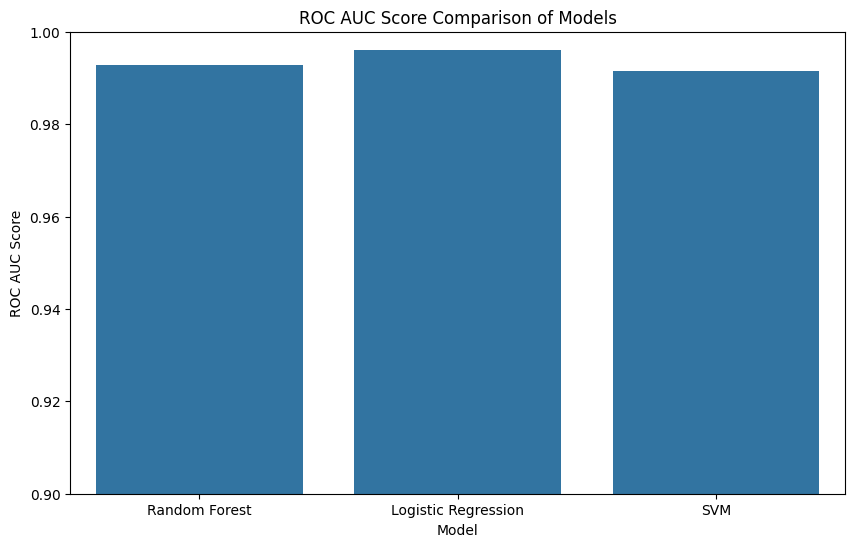

In [42]:
# Lets Visualize the models
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC AUC Score', data=performance_df)
plt.title('ROC AUC Score Comparison of Models')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.ylim(0.9, 1.0)
plt.show()

## Discussion and Recommendations

From the comparative analysis, all three models (Random Forest, Logistic Regression, and SVM) performed exceptionally well on the Breast Cancer Wisconsin dataset, achieving very high accuracy and ROC AUC scores. This suggests that the features extracted from the breast mass characteristics are highly effective in distinguishing between benign and malignant tumors.

### Key Findings:
*   **Logistic Regression** exhibited the highest ROC AUC score (0.9960) and an accuracy of 0.9737, indicating excellent discriminatory power and overall correct classifications.
*   **Random Forest** also performed very strongly with an accuracy of 0.9737 and a ROC AUC score of 0.9929. Its confusion matrix shows perfect precision for class 1 (malignant), but slightly lower recall compared to Logistic Regression.
*   **SVM** showed slightly lower accuracy (0.9649) and ROC AUC score (0.9914) compared to the other two, though still impressive. Its confusion matrix indicates a few more false negatives than Logistic Regression.

### Recommendations:
Given the high performance of all models, the choice between them might depend on specific operational requirements:
1.  **For maximum reliability in identifying malignant cases (minimizing false negatives)**: **Logistic Regression** appears to be the most robust choice with the highest ROC AUC and a strong balance of precision and recall. It effectively minimizes false negatives, which is crucial in medical diagnosis.
2.  **For a simpler, more interpretable model**: **Logistic Regression** is generally easier to interpret than Random Forest or SVM, making it a good choice if understanding feature contributions is important.
3.  **For potential further improvement with larger datasets or more complex relationships**: While Random Forest and SVM are powerful, their slight underperformance in this specific comparison suggests that the linear relationships captured by Logistic Regression are highly effective for this dataset. However, in more complex scenarios, these models might have an edge.

In conclusion, based on the provided metrics, **Logistic Regression** stands out as the best-performing model for this specific breast cancer classification task, offering a compelling balance of accuracy, discriminatory power, and interpretability.

## Summary:

### Q&A
*   **Which model performed best for this specific breast cancer classification task?**
    Logistic Regression performed best, exhibiting the highest ROC AUC score of 0.9960 and an accuracy of 0.9737.
*   **What are the key performance metrics for each model?**
    *   **Logistic Regression:** Accuracy: 0.9737, ROC AUC Score: 0.9960.
    *   **Random Forest:** Accuracy: 0.9737, ROC AUC Score: 0.9929.
    *   **SVM:** Accuracy: 0.9649, ROC AUC Score: 0.9914.
*   **What are the recommendations based on the comparison?**
    For maximum reliability in identifying malignant cases (minimizing false negatives) and for a simpler, more interpretable model, Logistic Regression is the most robust and recommended choice.

### Data Analysis Key Findings
*   All three models (Random Forest, Logistic Regression, and SVM) demonstrated exceptionally high performance on the breast cancer dataset, with accuracies ranging from 0.9649 to 0.9737 and ROC AUC scores from 0.9914 to 0.9960.
*   Logistic Regression achieved the highest ROC AUC score of 0.9960, closely followed by Random Forest at 0.9929, indicating superior discriminatory power.
*   Both Random Forest and Logistic Regression achieved the highest accuracy of 0.9737, slightly outperforming SVM's accuracy of 0.9649.
*   The confusion matrices showed that Logistic Regression had fewer false negatives (2) compared to Random Forest (3) and SVM (4), which is crucial for medical diagnosis.

### Insights or Next Steps
*   Given its superior ROC AUC score and strong balance of precision and recall (minimizing false negatives), Logistic Regression is the most robust and recommended model for this breast cancer classification task.
*   While all models performed well, the choice of Logistic Regression is also supported by its interpretability, which can be an advantage in medical applications where understanding feature contributions is important.
